## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

---

## Workbook Setup and Data Preparation

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [243]:
df_all = pd.read_csv('./data/dialog_norm.csv')
df_all.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

In [244]:
print(df_all.shape)
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)
print(df_all.shape)

(7708, 3)
(7705, 3)


In [245]:
print (df_all.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    1160
coffee-ordering-1      735
coffee-ordering-2      641
movie-finder            54
movie-tickets-1        678
movie-tickets-2        377
movie-tickets-3        195
pizza-ordering-1       257
pizza-ordering-2      1210
restaurant-table-1     704
restaurant-table-2     494
restaurant-table-3     102
uber-lyft-1            646
uber-lyft-2            452
dtype: int64


In [246]:
df_all.head(3)

,Instruction_id,category,selfdialog_norm
0,restaurant-table-2,0,hi im looking book table korean fod ok area thinking somewhere southern nyc maybe east village ok great theres thursday kitchen great reviews thats great need table tonight pm people dont want sit bar anywhere else fine dont availability pm times available yikes cant times ok second choice let check ok lets try boka free people yes great lets book ok great requests thats book great use account open yes please great get confirmation phone soon
1,movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir thank welcome


In [247]:
df_restaurant1 = df_all[df_all.Instruction_id == 'restaurant-table-1']
df_restaurant1 = df_restaurant1.sample(n=400)
df_restaurant2 = df_all[df_all.Instruction_id == 'restaurant-table-2']
df_restaurant2 = df_restaurant2.sample(n=400)
df_movie1 = df_all[df_all.Instruction_id == 'movie-tickets-1']
df_movie1 = df_movie1.sample(n=400)
df_auto1 = df_all[df_all.Instruction_id == 'auto-repair-appt-1']
df_auto1 = df_auto1.sample(n=400)
df_coffee1 = df_all[df_all.Instruction_id == 'coffee-ordering-1']
df_coffee1 = df_coffee1.sample(n=400)

In [248]:
df2 = pd.concat([df_restaurant1, df_restaurant2, df_movie1, df_auto1, df_coffee1], axis=0)

In [249]:
df_all = df2

In [250]:
len(df_all)

2000

#### Get a Sample of records.

In [251]:

#cat_id_df = df_all[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
cat_count = len(cat_id_df)
sample_size = 2000
sample_per_cat = sample_size//cat_count
print('sample_size: ', sample_size, 'sample_per_cat: ', sample_per_cat)


sample_size:  2000 sample_per_cat:  142


In [252]:
# Function to Get balanced Sample - Get a bit more than needed then down sample
def sampling_k_elements(group, k=sample_per_cat + 20):
    if len(group) < k:
        return group
    return group.sample(k, random_state=5, replace=True)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to sample_size
corpus_df = corpus_df.sample(n=sample_size, random_state=3, replace=True)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    385
coffee-ordering-1     394
movie-tickets-1       399
restaurant-table-1    393
restaurant-table-2    429
dtype: int64


#### Generate Corpus List

In [253]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm)

print(len(doc_lst))
doc_lst[1:5]

2000


['hey meg place order starbucks pick way meet client office minutes sure starbucks location would like pick coffee starbucks location durango elkhorn would like order would like venti caramel macchiato made nonfat milk would like hot iced blended iced whould like whip cream add flavor extra espresso shots thank options would like order food items order actually add chocolate swirl brioche order sure thing would like warmed sure would great confirm venti iced caramel macchiato made nonfat milk whip cream additives warm chocolate swirl brioche correct right perfect placing order perfect gathering things head door order ready minutes always busy like minutes awesome drive minutes thank okay sending order confirmation phone right perfect',
 'steak house open next monday evening date yes need plan th open mondays glad many restaurants take day time thinking coming brother sunset would table two available pm really seating times even numbered hours openings pm pm make reservation two diners 

#### Split Data into Train and Test Sets

In [254]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['category'], test_size=0.25, random_state = 0)

#### Build Vocabulary

In [255]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in X_train]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 4788
Vocabulary Sample: [('like', 1), ('would', 2), ('pm', 3), ('yes', 4), ('ok', 5), ('okay', 6), ('want', 7), ('thank', 8), ('please', 9), ('time', 10)]


### Bag of Words Feature Extraction

In [256]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(X_train, y_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 5, 5, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 2, ..., 0, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [257]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,pm,yes,ok,okay,want,thank,please,time,great,tickets,need,reservation,...,til,minnesota,smokefree,nosmoking,policy,idling,stoplight,sluggish,answers,awell,inputed,idle,slugging,accelaration,success
0,0,1,0,1,0,3,0,0,1,0,1,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,5,5,5,3,2,0,1,3,1,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,0,4,6,4,0,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,2,0,2,1,0,3,0,1,0,0,5,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,4,1,0,3,3,1,1,1,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,1,0,1,0,0,0,1,0,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1496,0,4,4,4,3,0,0,0,2,4,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1497,0,2,2,4,2,0,1,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1498,0,1,2,0,0,0,6,0,0,1,0,1,0,3,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [258]:
# Get BOW features
X_train_bow = cv_matrix #cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(1500, 4788)
(500, 4788)
(500,)


#### Define Model Builder Function

In [259]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

### Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [260]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [261]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [262]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
#df_benchmarks

In [263]:
from sklearn.metrics import confusion_matrix
#rm_nb_bow.cm

In [264]:
from sklearn import metrics
#print("Label" + rm_nb_bow.report)

### Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [265]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler):
    x_train_scaled = scaler.fit_transform(features_train, labels_train)
    x_test_scaled = scaler.transform(features_test)
    return x_train_scaled, x_test_scaled

def Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test):
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(features_train, labels_train)
    chi_support = chi_selector.get_support()    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    return X_train_chi, X_test_chi

def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test)
    x_train_scaled, x_test_scaled = Get_Scaled_Features(X_train_chi, labels_train, X_test_chi, labels_test, scaler)
    rm_chi = Build_Model(model, x_train_scaled, labels_train, x_test_scaled, labels_test)
    return rm_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [266]:
a = 100
tot = X_train_bow.shape[1]
b = 100 * (tot//100)
c = 100
print(a, b, c)

100 4700 100


In [267]:
rows = []

scaler_min_max = MinMaxScaler()
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

In [268]:
#acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [269]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

4550 4650 1


#### Get a more fine-grained look at the optimal number of features region

In [270]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [271]:
#acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [272]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

4550


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [273]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [274]:
#print(rm_chi_opt_bow.cm)

In [275]:
#print("Label" + rm_chi_opt_bow.report)

In [276]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.9713156,0.9700000,0.9698328,0.9700000
1,BOW Naive Bayes Optimal Features Selected: 4550,BOW,0.9713156,0.9700000,0.9698328,0.9700000


---

## 1. Benchmark Comparison

### Benchmark the following four models: Logistic Regression (Multinomial) Naive Bayes Linear Support Vector Machine Random Forest

#### Baseline Features

In [277]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_bow, y_train, scoring='f1_weighted', cv=CV)
    precisions = cross_val_score(model, X_train_bow, y_train, scoring='precision_weighted', cv=CV)
    recalls = cross_val_score(model, X_train_bow, y_train, scoring='recall_weighted', cv=CV)
    
    for i in range(0, 4, 1):
        entries.append((model_name, 'baseline', precisions[i], recalls[i], f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['model_name', 'features', 'precision', 'recall', 'f1_score'])       

#### Optimised Features

In [278]:
models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
#entries = []

for model in models:
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='f1_weighted', cv=CV)
    precisions = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='precision_weighted', cv=CV)
    recalls = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='recall_weighted', cv=CV)

    for i in range(0, 4, 1):
        entries.append((model_name, 'optimized', precisions[i], recalls[i], f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['model_name', 'features', 'precision', 'recall', 'f1_score'])        

In [279]:

models_df = cv_df.groupby(['model_name','features']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

precision_mean  recall_mean  f1_score_mean
model_name             features                                             
LinearSVC              baseline        0.9788835    0.9783333      0.9782868
                       optimized       0.9789816    0.9783333      0.9782854
LogisticRegression     baseline        0.9806342    0.9800000      0.9799670
                       optimized       0.9831335    0.9825000      0.9824584
MultinomialNB          baseline        0.9710731    0.9700000      0.9698594
                       optimized       0.9732872    0.9725000      0.9723842
RandomForestClassifier baseline        0.9804763    0.9775000      0.9815869
                       optimized       0.9834185    0.9783333      0.9816095

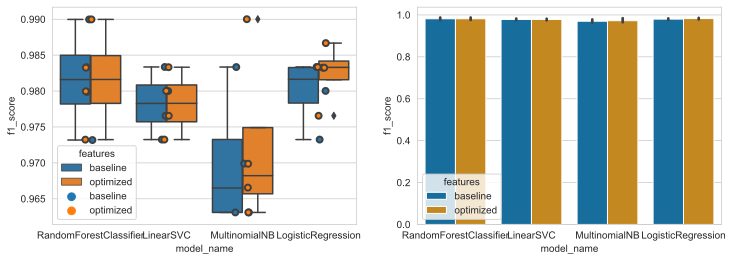

In [280]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)
sns.boxplot(x='model_name', y='f1_score', data=cv_df, hue='features', ax=ax1);
sns.stripplot(x='model_name', y='f1_score', data=cv_df, hue='features', size=6, jitter=True, edgecolor="gray", linewidth=2, ax=ax1);
sns.barplot(y='f1_score', x='model_name', data=cv_df, palette="colorblind", hue='features', ax=ax2);


## Optimize the Hyperparameters Using Grid Search

In [281]:
from sklearn.model_selection import GridSearchCV

class Estimator_Parameters:
    def __init__(self, estimator, parameters, feat_type, x, y):
        self.estimator = estimator
        self.parameters = parameters
        self.feat_type = feat_type
        self.x = x
        self.y = y

def Get_Best_Parameters(est_param):
    grid_search = GridSearchCV(estimator = est_param.estimator,
                            param_grid = est_param.parameters,
                            scoring = 'f1_weighted',
                            cv= 10,
                            n_jobs = -1)
    grid_search = grid_search.fit(est_param.x, est_param.y)
    return grid_search.best_score_, grid_search.best_params_

In [282]:
from sklearn.model_selection import GridSearchCV

est_param_arr = [
    Estimator_Parameters(RandomForestClassifier(), [{'n_estimators': [50,100,150,200,250,300],'max_depth': [1, 2, 3,4,5], 'random_state': [0,1,2,3]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(LinearSVC(), [{'C': [1000, 1400, 1500, 1600],'loss': ['hinge', 'squared_hinge'], 'dual': [True, False], 'penalty': ['l1', 'l2'], 'max_iter': [1000, 1500, 2000]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(MultinomialNB(), [{'alpha': [0.1,0.2,0.3,0.4,0.42,0.44,0.46,0.48,0.5],'fit_prior': [True, False]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(LogisticRegression(), [{'C': [1,2,3], 'penalty': ['l1', 'l2', 'elasticnet', 'none'],'dual': [True, False], 'multi_class': ['auto', 'ovr', 'multinomial']}], "optimized", rm_chi_opt_bow.x_train_sel, y_train)
]
rows = []
for est_param in est_param_arr:
    estimator_name = est_param.estimator.__class__.__name__
    best_accuracy, best_parameters = Get_Best_Parameters(est_param)
    rows.append([estimator_name, best_accuracy, str(best_parameters), est_param.feat_type])
    print(estimator_name, best_accuracy, best_parameters, est_param.feat_type)

RandomForestClassifier 0.9181637620001404 {'max_depth': 5, 'n_estimators': 200, 'random_state': 1} optimized
LinearSVC 0.9799559062405316 {'C': 1000, 'dual': True, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'} optimized
MultinomialNB 0.9786296486668238 {'alpha': 0.1, 'fit_prior': True} optimized
LogisticRegression 0.9832979949510487 {'C': 1, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'} optimized


In [283]:
result_df = pd.DataFrame(rows, columns=["Estimator", "Best_F1_Score", "Best_Params", "Feat_Type"])
result_df

,Estimator,Best_F1_Score,Best_Params,Feat_Type
0,RandomForestClassifier,0.9181638,"{'max_depth': 5, 'n_estimators': 200, 'random_state': 1}",optimized
1,LinearSVC,0.9799559,"{'C': 1000, 'dual': True, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}",optimized
2,MultinomialNB,0.9786296,"{'alpha': 0.1, 'fit_prior': True}",optimized
3,LogisticRegression,0.9832980,"{'C': 1, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}",optimized


## 2. a. Learning Curves: Training/ Testing Errors - Optimized Hyperarameters

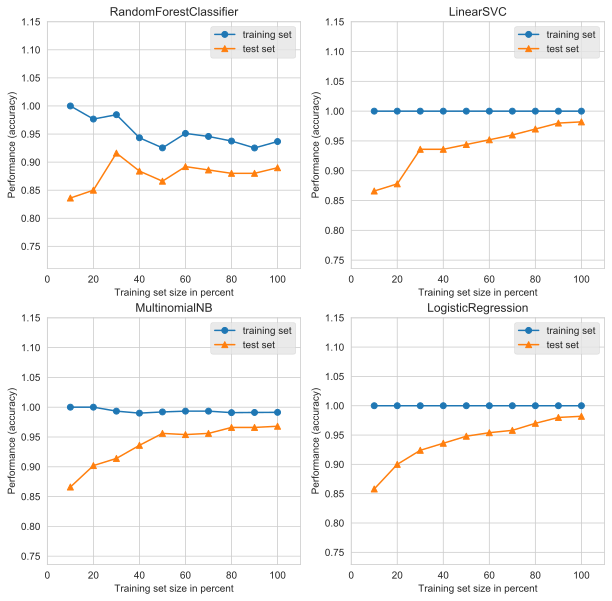

In [284]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.gridspec as gridspec
import itertools

models = [
    RandomForestClassifier(n_estimators=250, max_depth=5, random_state=2),
    LinearSVC(C=1000, dual=False, loss='squared_hinge', max_iter=1000, penalty='l2'),
    MultinomialNB(alpha=0.3, fit_prior=False),
    LogisticRegression(C=1, dual=False, multi_class='ovr', penalty='l2'),
]

#fig2 = plt.figure(figsize=(10, 10))
fig3 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    #fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    fig3 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, scoring='accuracy', print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

---

## 2. b. Learning Curves: Scores, Performance and Scalability - Optimized Hyperarameters

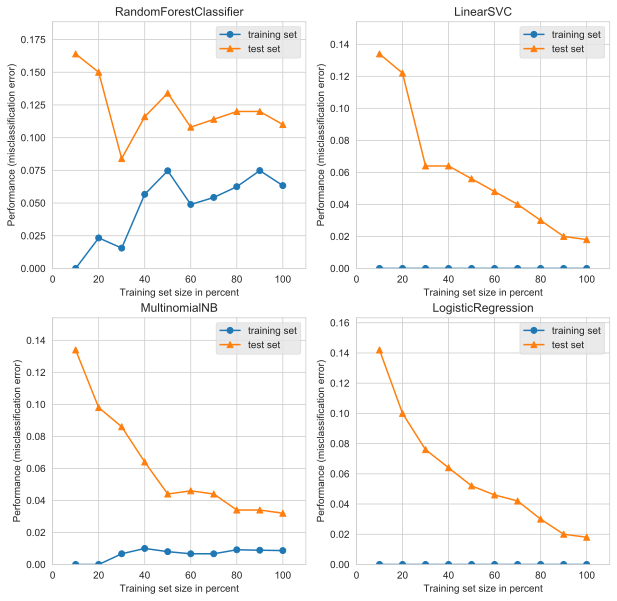

In [288]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.gridspec as gridspec
import itertools

models = [
    RandomForestClassifier(n_estimators=250, max_depth=5, random_state=2),
    LinearSVC(C=1000, dual=False, loss='squared_hinge', max_iter=1000, penalty='l2'),
    MultinomialNB(alpha=0.3, fit_prior=False),
    LogisticRegression(C=1, dual=False, multi_class='ovr', penalty='l2'),
]

fig2 = plt.figure(figsize=(10, 10))
#fig3 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    #fig3 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, scoring='accuracy', print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

In [285]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [286]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

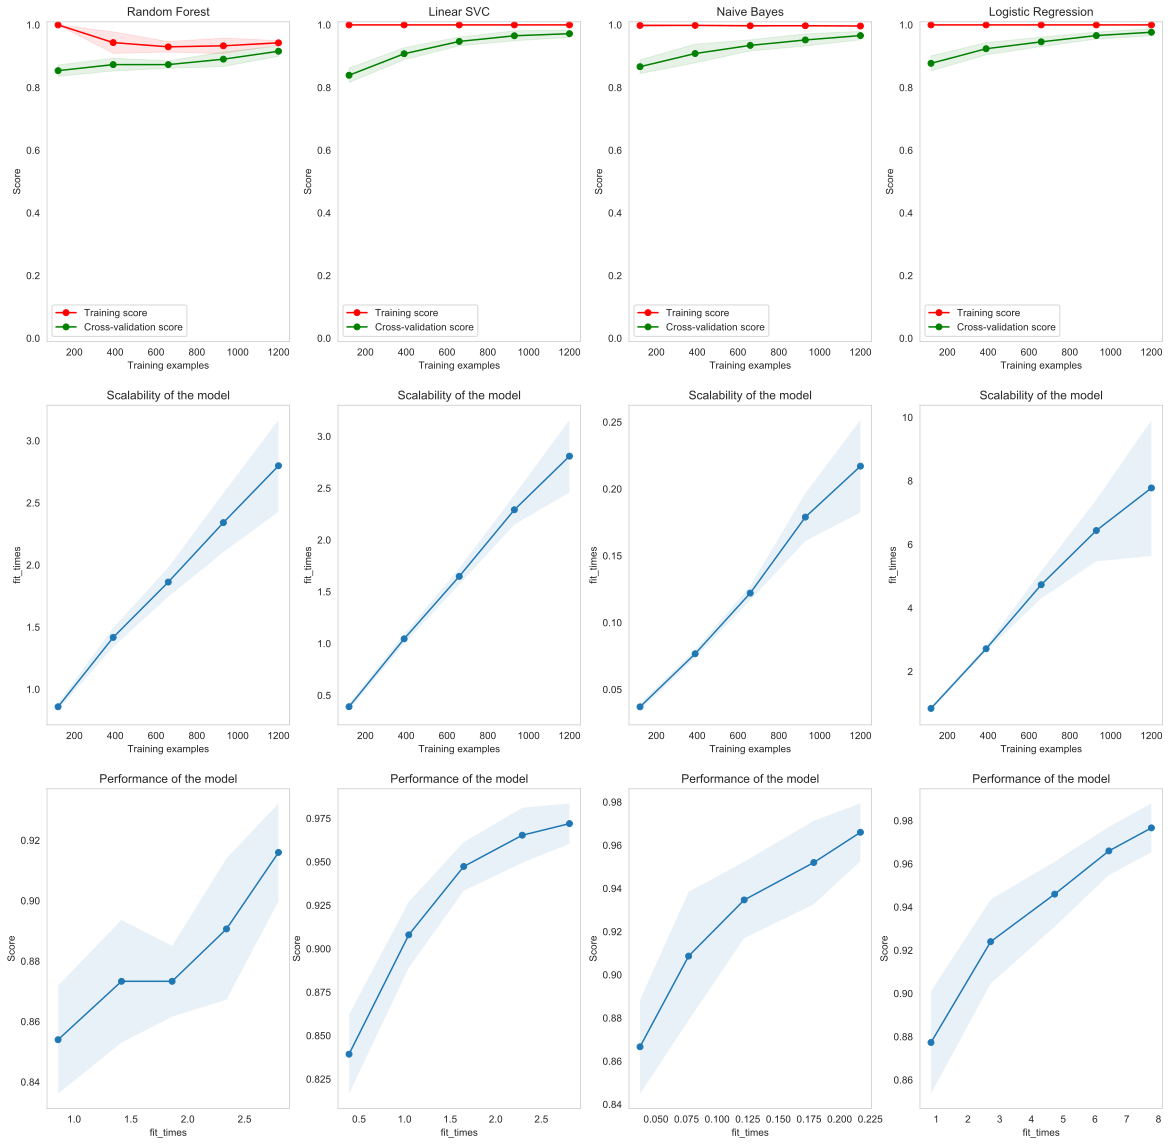

In [287]:
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
#X_train_bow
#X, y = rm_chi_opt_bow.x_train_sel, y_train
X, y = X_train_bow, y_train

title = "Random Forest"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(max_depth=5, n_estimators=300, random_state=1)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(-0.01, 1.01),
                    cv=cv, n_jobs=-1)

title = "Linear SVC"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LinearSVC(C=1400, dual=False, loss='squared_hinge', max_iter=1500, penalty='l1')
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(-0.01, 1.01),
                    cv=cv, n_jobs=-1)

title = "Naive Bayes"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = MultinomialNB(alpha=0.1, fit_prior=True)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 2], ylim=(-0.01, 1.01),
                    cv=cv, n_jobs=-1)

title = "Logistic Regression"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression(C=3, dual=False, multi_class='ovr', penalty='l2')
plot_learning_curve(estimator, title, X, y, axes=axes[:, 3], ylim=(-0.01, 1.01),
                    cv=cv, n_jobs=-1)


plt.show();

---

## 3. Ensemble Learning

#### Initialize Models with optimized hyperparameters

In [289]:
clf1 = RandomForestClassifier(max_depth=5, n_estimators = 300, random_state = 1)
clf2 = LinearSVC(C=1400, dual=False, loss='squared_hinge', max_iter=1500, penalty='l1')
clf3 = MultinomialNB(alpha=0.1, fit_prior=True)
clf4 = LogisticRegression(C=3, dual=False, multi_class='ovr', penalty='l2')

## Bagging

In [290]:
from sklearn.ensemble import BaggingClassifier

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=10, max_samples=0.8, max_features=0.8)

In [291]:
import itertools
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec

labels = ['Random Forest', 'LinearSVC', 'MultinomialNB', 'LogisticRegression', 'Bagging Forest', 'Bagging SVC', 'Bagging NB','Bagging LR']
clf_list = [clf1, clf2, clf3, clf4, bagging1, bagging2, bagging3, bagging4]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 4)
grid = itertools.product([0,1],repeat=4)

for clf, label, grd in zip(clf_list, labels, grid):        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
#     clf.fit(rm_chi_opt_bow.x_train_sel, y_train)
#     ax = plt.subplot(gs[grd[0], grd[1]])
#     fig = plot_decision_regions(X=rm_chi_opt_bow.x_train_sel, y=y_train, clf=clf, legend=2)
#     plt.title(label)

# plt.show()

Accuracy: 0.92 (+/- 0.01) [Random Forest]
Accuracy: 0.96 (+/- 0.01) [LinearSVC]
Accuracy: 0.96 (+/- 0.01) [MultinomialNB]
Accuracy: 0.97 (+/- 0.01) [LogisticRegression]
Accuracy: 0.91 (+/- 0.02) [Bagging Forest]
Accuracy: 0.97 (+/- 0.01) [Bagging SVC]
Accuracy: 0.96 (+/- 0.01) [Bagging NB]
Accuracy: 0.96 (+/- 0.01) [Bagging LR]


<Figure size 1000x800 with 0 Axes>

## Learning Curves for Bagged Models

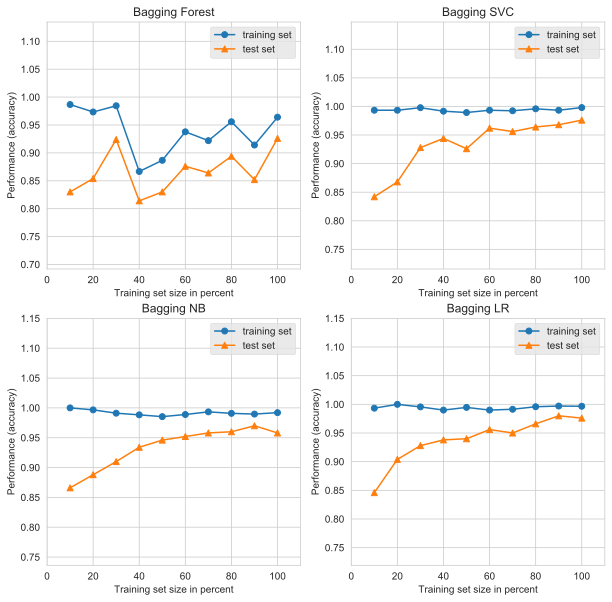

In [292]:
from mlxtend.plotting import plot_learning_curves

models = [
    bagging1, bagging2, bagging3, bagging4
]
labels = ['Bagging Forest', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, label, grd in zip(models, labels, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, scoring='accuracy', print_model=False, style='ggplot')
    plt.title(label)
         
plt.show()

---

In [72]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

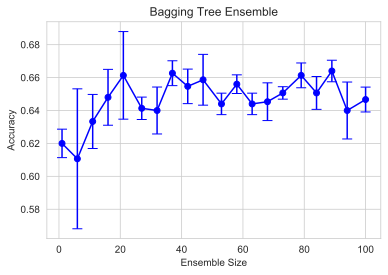

In [73]:
num_est = list(map(int, np.linspace(1,100,20)))
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

## Boosting

In [293]:
from sklearn.ensemble import AdaBoostClassifier

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf1, n_estimators=n_est)   
    boosting.fit(rm_chi_opt_bow.x_train_sel, y_train)

<Figure size 1000x800 with 0 Axes>

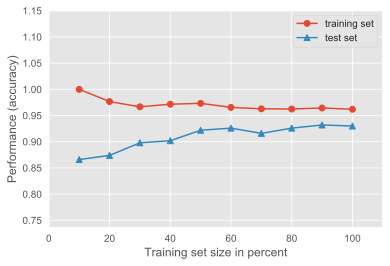

In [294]:
#plot Boosting learning curve
boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
        
plt.figure()
plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, boosting, scoring='accuracy', print_model=False, style='ggplot')
plt.show()

In [76]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

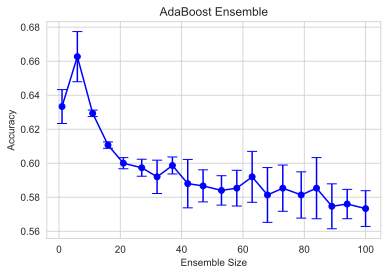

In [77]:
num_est = list(map(int, np.linspace(1,100,20)))
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

## Stacking

In [78]:
from mlxtend.classifier import StackingClassifier

lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=clf4)

labels = ['Random Forest', 'LinearSVC', 'MultinomialNB', 'Stacking LR']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, labels, grid):
        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    #clf.fit(X, y)
    # ax = plt.subplot(gs[grd[0], grd[1]])
    # fig = plot_decision_regions(X=X, y=y, clf=clf)
    # plt.title(label)

# plt.show()

Accuracy: 0.64 (+/- 0.00) [Random Forest]
Accuracy: 0.66 (+/- 0.01) [LinearSVC]
Accuracy: 0.76 (+/- 0.02) [MultinomialNB]
Accuracy: 0.40 (+/- 0.02) [Stacking LR]


<Figure size 1000x800 with 0 Axes>

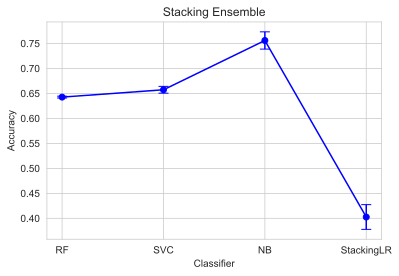

In [79]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['RF', 'SVC', 'NB', 'StackingLR'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

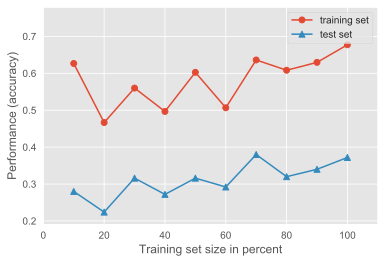

In [88]:
#plot Stacking learning curve
plt.figure()
plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, sclf, scoring='accuracy', print_model=False, style='ggplot')
plt.show()